# Basic test of Coiled processing NASA earthdata using Xarray and s3fs libraries with kerhunk

**`earthaccess` library**

This notebook requires a version of `earthaccess` that is not distributed yet. However, it can be installed with 
```
pip install git+https://github.com/jrbourbeau/earthaccess.git@kerchunk
```

In [1]:
!pip uninstall -y earthaccess

Found existing installation: earthaccess 0.5.3
Uninstalling earthaccess-0.5.3:
  Successfully uninstalled earthaccess-0.5.3


In [2]:
!pip install git+https://github.com/jrbourbeau/earthaccess.git@kerchunk

  Cloning https://github.com/jrbourbeau/earthaccess.git (to revision kerchunk) to ./pip-req-build-mofia76m
  Running command git clone --filter=blob:none --quiet https://github.com/jrbourbeau/earthaccess.git /tmp/pip-req-build-mofia76m
  Running command git checkout -b kerchunk --track origin/kerchunk
  Switched to a new branch 'kerchunk'
  Branch 'kerchunk' set up to track remote branch 'kerchunk' from 'origin'.
  Resolved https://github.com/jrbourbeau/earthaccess.git to commit cd260a51873d0e443f9973e0d2aba9fd7aa82680
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for earthaccess: filename=earthaccess-0.5.3-py3-none-any.whl size=54951 sha256=05cc0812f68c284af038ff4572b30b5546d909c48b7df8a6aead7ba577b7d2fe
  Stored in directory: /tmp/pip-ephem-wheel-cache-6qcfthsp/wheels/0f/ca/94/bde2bd74cba95c734bae2e80f1c3c4edc1af68efe0f27df536
Successfully built earthaccess


In [3]:
# Access libraries
import s3fs
import requests
import earthaccess

# Parallel computing libraries
import coiled
import dask
#from dask.distributed import Client, LocalCluster

# Data analysis libraries
import xarray as xr

# Visualization libraries
import matplotlib.pyplot as plt
%matplotlib inline

## Start cluster

In [4]:
cluster = coiled.Cluster(
    n_workers=10, 
    account="podaac-science", 
    region="us-west-2", 
    #worker_memory="64 GiB",
    #name='podaac-science-c0a69b8d-e'
    ) 
client = cluster.get_client()
client

Output()

Package - coiled_local_basic_tests, Built wheel does not contain all python files!

╭────────────────────────────────────────── Package Info ──────────────────────────────────────────╮
│                            ╷                                                                     │
│   Package                  │ Note                                                                │
│ ╶──────────────────────────┼───────────────────────────────────────────────────────────────────╴ │
│   coiled_local_basic_tests │ Source wheel built from                                             │
│                            │ /opt/coiled/rt/.path-deps/coiled_local_basic_tests-0.0.0-py3-none   │
│                            │ -any.whl                                                            │
│   earthaccess              │ Wheel built from                                                    │
│                            │ git+https://github.com/jrbourbeau/earthaccess.git@cd260a51873d0e4   │
│                            │ 43f9973e0d2aba9fd7aa82680                                           │
│                            ╵                                                                     │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────── Not Synced with Cluster ─────────────────────────────────────╮
│                               ╷                                                      ╷           │
│   Package                     │ Error                                                │ Risk      │
│ ╶─────────────────────────────┼──────────────────────────────────────────────────────┼─────────╴ │
│   coiled_local_basic_tests    │ Built wheel does not contain all python files!       │ Warning   │
│                               ╵                                                      ╵           │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯

Output()

Connection method: Cluster object,Cluster type: coiled.Cluster
Dashboard: https://cluster-pikom.dask.host/xvUoM7aauTeuuoKh/status,
Dashboard: https://cluster-pikom.dask.host/xvUoM7aauTeuuoKh/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tls://10.0.57.207:8786,Workers: 0
Dashboard: https://cluster-nhamx.dask.host/jupyter/proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


## Locate files using `earthaccess`

In [5]:
earthaccess.login()

EARTHDATA_USERNAME and EARTHDATA_PASSWORD are not set in the current environment, try setting them or use a different strategy (netrc, interactive)
No .netrc found in /home/mambauser


Enter your Earthdata Login username:  deanh808
Enter your Earthdata password:  ········


You're now authenticated with NASA Earthdata Login
Using token with expiration date: 10/21/2023
Using user provided credentials for EDL


In [6]:
results = earthaccess.search_data(
    short_name="MUR-JPL-L4-GLOB-v4.1",
    cloud_hosted=True,
    #bounding_box=bounding_box,
    #temporal=("2021-04-01", "2021-05-6"),
    count=50,
    )

Granules found: 7749


## Load data with kerchunk and xarray

In [7]:
%%time

# Consolidated metdata file
metadata = earthaccess.consolidate_metadata(
    results,
    kerchunk_options={
        "concat_dims": "time", 
        }, 
    #outfile="some S3 path"
)

CPU times: user 828 ms, sys: 56.2 ms, total: 884 ms
Wall time: 23.3 s


In [26]:
"""
%%time

@dask.delayed
def open_dataset(*args, **kwargs):
    # This is a simple wrapper around Xarray's open_dataset.
    # We use `dask.delayed` to make sure the `xr.open_dataset`
    # call happens on our cluster in us-west-2 so we have proper
    # S3 acess.
    return xr.open_dataset(*args, **kwargs)

fs = earthaccess.get_s3fs_session(daac="PODAAC")
ds = open_dataset(
    "reference://",
    engine="zarr",
    chunks={},
    backend_kwargs={
        "consolidated": False,
        "storage_options": {
            "fo": metadata,
            "remote_protocol": "s3",
            "remote_options": fs.storage_options,
        }
    },
).compute()
"""

/Users/henze/miniconda3/envs/coiled/lib/python3.11/site-packages/distributed/client.py:3160: UserWarning: Sending large graph of size 12.71 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


CPU times: user 3.79 s, sys: 158 ms, total: 3.95 s
Wall time: 26.1 s


In [8]:
fs = earthaccess.get_s3fs_session(daac="PODAAC")
ds = xr.open_dataset(
    "reference://",
    engine="zarr",
    chunks={},
    backend_kwargs={
        "consolidated": False,
        "storage_options": {
            "fo": metadata,
            "remote_protocol": "s3",
            "remote_options": fs.storage_options,
        }
    },
)

In [9]:
ds

<xarray.Dataset>
Dimensions:           (time: 50, lat: 17999, lon: 36000)
Coordinates:
  * lat               (lat) float32 -89.99 -89.98 -89.97 ... 89.97 89.98 89.99
  * lon               (lon) float32 -180.0 -180.0 -180.0 ... 180.0 180.0 180.0
  * time              (time) datetime64[ns] 2002-06-01T09:00:00 ... 2002-07-2...
Data variables:
    analysed_sst      (time, lat, lon) float32 dask.array<chunksize=(1, 1023, 2047), meta=np.ndarray>
    analysis_error    (time, lat, lon) float32 dask.array<chunksize=(1, 1023, 2047), meta=np.ndarray>
    mask              (time, lat, lon) float32 dask.array<chunksize=(1, 1447, 2895), meta=np.ndarray>
    sea_ice_fraction  (time, lat, lon) float32 dask.array<chunksize=(1, 1447, 2895), meta=np.ndarray>
Attributes: (12/47)
    Conventions:                CF-1.5
    Metadata_Conventions:       Unidata Observation Dataset v1.0
    acknowledgment:             Please acknowledge the use of these data with...
    cdm_data_type:              grid
    comment:                    MUR = "Multi-scale Ultra-high Reolution"
    creator_email:              ghrsst@podaac.jpl.nasa.gov
    ...                         ...
    summary:                    A merged, multi-sensor L4 Foundation SST anal...
    time_coverage_end:          20020601T210000Z
    time_coverage_start:        20020531T210000Z
    title:                      Daily MUR SST, Final product
    uuid:                       27665bc0-d5fc-11e1-9b23-0800200c9a66
    westernmost_longitude:      -180.0

In [10]:
ds['analysed_sst']

<xarray.DataArray 'analysed_sst' (time: 50, lat: 17999, lon: 36000)>
dask.array<open_dataset-analysed_sst, shape=(50, 17999, 36000), dtype=float32, chunksize=(1, 1023, 2047), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 -89.99 -89.98 -89.97 -89.96 ... 89.97 89.98 89.99
  * lon      (lon) float32 -180.0 -180.0 -180.0 -180.0 ... 180.0 180.0 180.0
  * time     (time) datetime64[ns] 2002-06-01T09:00:00 ... 2002-07-20T09:00:00
Attributes:
    comment:        "Final" version using Multi-Resolution Variational Analys...
    long_name:      analysed sea surface temperature
    source:         AMSRE-REMSS, AVHRR_Pathfinder-PFV5.2-NODC_day, AVHRR_Path...
    standard_name:  sea_surface_foundation_temperature
    units:          kelvin
    valid_max:      32767
    valid_min:      -32767

## Computations

In [11]:
# Function meant to be run with dask.
# Takes an xarray.DataArray (with dimensions lat, lon), subsets spatially using
# input 2-tuples, returns mean over the subsetted region.
def regional_spatial_mean(sstdata, latbnds, lonbnds):
    future_result = sstdata.sel(lat=slice(*latbnds), lon=slice(*lonbnds)) # subset
    future_result = future_result.mean(dim=['lat','lon'], skipna=True) # mean
    return future_result.load()

In [12]:
## Bounding boxes for two regions to perform computations over

# Sub-tropical western Atlantic region:
latbnds1 = (20, 30)
lonbnds1 = (-82, -72)

# Mid-latitude eastern Pacific region:
latbnds2 = (45, 55)
lonbnds2 = (-137, -127)

In [13]:
%%time

# Computations
region1_mean_sst = regional_spatial_mean(ds['analysed_sst'], latbnds1, lonbnds1)
region2_mean_sst = regional_spatial_mean(ds['analysed_sst'], latbnds2, lonbnds2)

CPU times: user 133 ms, sys: 4.02 ms, total: 137 ms
Wall time: 5.15 s


Text(0, 0.5, 'SST [K]')

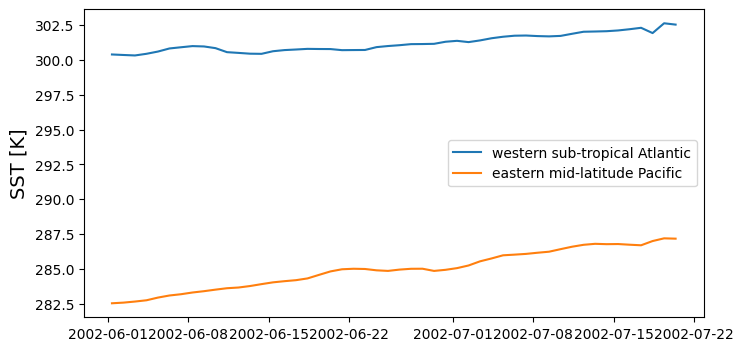

In [14]:
## Plot results

fig = plt.figure(figsize=(8, 4))
axes = plt.axes()

axes.plot(region1_mean_sst['time'], region1_mean_sst.values, label='western sub-tropical Atlantic')
axes.plot(region2_mean_sst['time'], region2_mean_sst.values, label='eastern mid-latitude Pacific')

axes.legend()
axes.set_ylabel('SST [K]', fontsize=14)

In [15]:
cluster.shutdown()